In [1]:
import jax
jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update('jax_platforms', 'cpu')
import numpy as np
import functools

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append('../fft_helpers/')

from projection_operators import compute_Ghat_4_2
import tensor_operators as tens

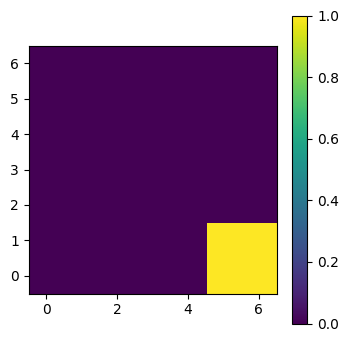

In [22]:
H, L = (7, 7)
Hmid = int(H/2)
Lmid = int(L/2)
r = int(H/3)

structure = np.zeros((H, L))
structure[:r, -r:] += rectangle(r, r)

plt.figure(figsize=(4, 4))
cb = plt.imshow(structure, origin='lower')
plt.colorbar(cb)

In [23]:
ndim = len(structure.shape)
N    = structure.shape[0] 

# grid dimensions
shape  = [N, N]         # number of voxels in all directions

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


In [24]:
# identity tensor (single tensor)
i    = jnp.eye(ndim)

# identity tensors (grid)
I    = jnp.einsum('ij,xy'          ,                  i   ,jnp.ones([N,N]))  # 2nd order Identity tensor
I4   = jnp.einsum('ijkl,xy->ijklxy',jnp.einsum('il,jk',i,i),jnp.ones([N,N])) # 4th order Identity tensor
I4rt = jnp.einsum('ijkl,xy->ijklxy',jnp.einsum('ik,jl',i,i),jnp.ones([N,N]))
I4s  = (I4+I4rt)/2.

II   = tens.dyad22(I,I)

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft = 0
- Hard = 1

In [25]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=['soft', 'hard'])
def param(X, soft, hard):
    return soft*jnp.ones_like(X)*(X)+hard*jnp.ones_like(X)*(1-X)

In [26]:
# material parameters
elastic_modulus = {"hard": 5.7, "soft": 0.57}  # N/mm2
poisson_modulus = {"hard": 0.386, "soft": 0.386}

# lames constant
lambda_modulus = {}
shear_modulus = {}
bulk_modulus = {}

for key in elastic_modulus.keys():
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

In [27]:
# material parameters
K      = param(structure,   soft=bulk_modulus['soft'],            hard=bulk_modulus['hard']        )  # bulk      modulus
mu     = param(structure,   soft=shear_modulus['soft'],           hard=shear_modulus['hard']        )  # shear     modulus


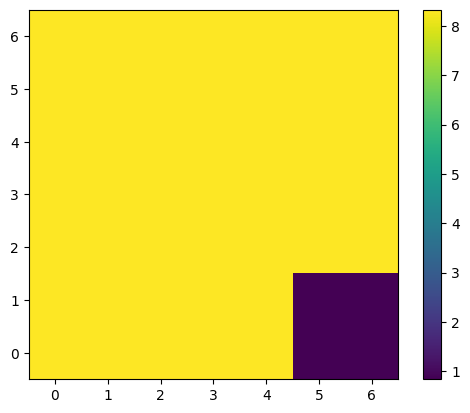

In [28]:
plt.imshow(K, origin='lower')
plt.colorbar()

In [29]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,)*ndim, operator='fourier', length=1.)

In [30]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn (jnp.fft.ifftshift(x),[N,N]))

@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x),[N,N]))

# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return  jnp.real( ifft( tens.ddot42(Ghat4_2,fft(A2)) ) ).reshape(-1)

@jax.jit
def K_dF(dF, K4):
    #jax.debug.print('x={}', K4)
    return tens.trans2(tens.ddot42(K4, tens.trans2(dF.reshape(ndim,ndim,N,N)) ))

@jax.jit
def G_K_dF(dF, K4):
    return G(K_dF(dF, K4))

In [31]:
# constitutive model: grid of "F" -> grid of "P", "K4"        [grid of tensors]
#@jax.jit
def constitutive(F):
    C4 = K*II+2.*mu*(I4s-1./3.*II)
    S  = tens.ddot42(C4,.5*(tens.dot22(tens.trans2(F),F)-I))
    P  = tens.dot22(F,S)
    K4 = tens.dot24(S,I4)+tens.ddot44(tens.ddot44(I4rt,tens.dot42(tens.dot24(F,C4),tens.trans2(F))),I4rt)
    return P,K4

# defining conjugate gradient solver

Here, we define a `conjugate gradient` solver for solving the linear equation

In [32]:
@functools.partial(jax.jit, static_argnums=(0,))
def conjgrad(A, b, K4, atol=1e-5):

    b, K4 = jax.device_put((b, K4))

    iiter = 0
    def body_fun(state):
        b, p, r, rsold, x, iiter =  state
        Ap = A(p, K4) 
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r) 
        p = r + (rsnew/rsold)*p
        rsold = rsnew
        iiter += 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.sqrt(rsold) > atol

    x = jnp.zeros_like(b)
    r = b - A(x, K4)
    p = r
    rsold = jnp.vdot(r, r) #jnp.dot(jnp.transpose(r), r)
    
    b, p, r, rsold, x, iiter = jax.lax.while_loop(cond_fun, body_fun, (b, p, r, rsold, x, iiter) )
    return x, iiter

## newton raphson method

Here we define a function to solve the hyperelasticity problem using a `newton-raphson` method

In [40]:
@jax.jit
def solve_netwon_raphson(state, n):
    dF, b, F, Fn, K4, iiter = state

    error = jnp.linalg.norm(dF)/Fn
    jax.debug.print('residual={}', error)

    def true_fun(state):
        dF, b, F, Fn, K4, iiter = state

        dF, iiter_cg = conjgrad(
                atol=1e-8,
                A = G_K_dF,
                b = b,
                K4= K4,
        )                                   # solve linear system using CG

        dF     = dF.reshape(ndim,ndim,N,N)
        F      = jax.lax.add(F, dF)         # update DOFs (array -> tens.grid)
        P, K4  = constitutive(F)            # new residual stress
        jax.debug.print("K4={}", K4)
        jax.debug.print("P={}", P)
 
        b      = -G(P)                      # convert residual stress to residual
        iiter = iiter.at[n, 0].set(iiter_cg)
        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF)/Fn)
        
        return (dF,  b, F, Fn, K4, iiter)

    def false_fun(state):
        dF, b, F, Fn, K4, iiter = state

        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF)/Fn)
  
        return (dF,  b, F, Fn, K4, iiter)


    return jax.lax.cond(error > 1e-6, true_fun, false_fun, state), n

In [41]:
F = jnp.array(I, copy=True)
P, K4  = constitutive(F)  
# set macroscopic loading
DbarF = jnp.zeros([ndim,ndim,N,N])
DbarF = DbarF.at[0, 1].add(0.05)

# initial residual: distribute "barF" over grid using "K4"
b     = -G_K_dF(DbarF, K4)
F     = jax.lax.add(F, DbarF) 
Fn    = jnp.linalg.norm(F)

P, K4  = constitutive(F)

In [42]:
iiter = jnp.zeros((10, 2))
state = (DbarF, b, F, Fn, K4, iiter)
initial_state = jax.device_put(state)

In [43]:
import timeit
import tracemalloc

In [44]:
start_time = timeit.default_timer()
# starting the monitoring
tracemalloc.start()
final_state, xs = jax.lax.scan(solve_netwon_raphson, 
                               init=initial_state, 
                               xs=jnp.arange(0, 10))
# displaying the memory
print(tracemalloc.get_traced_memory()[1], 'B')
final_time = timeit.default_timer()

# stopping the library
tracemalloc.stop()

print(final_time-start_time)

residual=0.035333262666878675
K4=[[[[[[ 1.11597106e+01  1.10096577e+01  1.10867849e+01  1.11717950e+01
       1.10324505e+01  1.05967267e+00  1.15901520e+00]
     [ 1.10324505e+01  1.11717950e+01  1.10867849e+01  1.10096577e+01
       1.11597106e+01  1.15901520e+00  1.05967267e+00]
     [ 1.09580460e+01  1.11515157e+01  1.10900196e+01  1.10298795e+01
       1.12108907e+01  1.12733899e+01  1.09321693e+01]
     [ 1.09590660e+01  1.10640636e+01  1.10880590e+01  1.11062696e+01
       1.12153919e+01  1.12151778e+01  1.09913864e+01]
     [ 1.10879123e+01  1.10836432e+01  1.10844382e+01  1.10836432e+01
       1.10879123e+01  1.11043719e+01  1.11043719e+01]
     [ 1.12153919e+01  1.11062696e+01  1.10880590e+01  1.10640636e+01
       1.09590660e+01  1.09913864e+01  1.12151778e+01]
     [ 1.12108907e+01  1.10298795e+01  1.10900196e+01  1.11515157e+01
       1.09580460e+01  1.09321693e+01  1.12733899e+01]]

    [[ 3.25674848e-01  5.26258720e-01  4.95806668e-01  5.25104514e-01
       3.28223049e-0

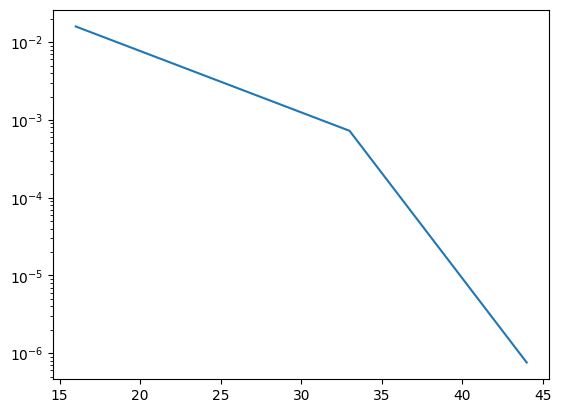

In [38]:
plt.semilogy(np.cumsum(final_state[-1].at[:, 0].get()), final_state[-1].at[:, 1].get())

In [31]:
#np.savetxt('./additional_data/normal-hyperelasticity.txt', final_state[-1])

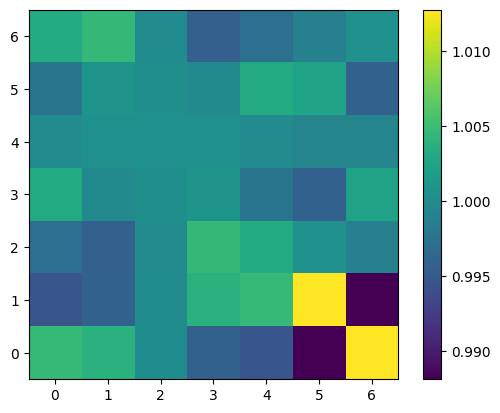

In [39]:
plt.imshow(final_state[2].at[1, 1].get(), origin='lower')
plt.colorbar()